In [179]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose 
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import make_scorer 
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import os



In [180]:
df=pd.read_csv('all_stocks_5yr.csv')
# df.dropna(inplace=True)
perc =[.20, .40, .60, .80] 
include =['object', 'float', 'int'] 
desc = df.describe(percentiles = perc, include = include) 
desc

,date,open,high,low,close,Name
count,619040,619029.000000,619032.000000,619032.000000,619040.000000,619040
unique,1259,NaN,NaN,NaN,NaN,505
top,2/7/2018,NaN,NaN,NaN,NaN,PXD
freq,505,NaN,NaN,NaN,NaN,1259
mean,NaN,83.023334,83.778311,82.256096,83.043763,NaN
std,NaN,97.378769,98.207519,96.507421,97.389748,NaN
min,NaN,1.620000,1.690000,1.500000,1.590000,NaN
20%,NaN,35.888000,36.240000,35.520000,35.890000,NaN
40%,NaN,52.810000,53.301660,52.330000,52.830000,NaN
50%,NaN,62.590000,63.150000,62.020000,62.620000,NaN


In [181]:
df.isnull().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

In [182]:
df['open'] = df['open'].fillna((df['open'].mean()))
df['high'] = df['high'].fillna((df['high'].mean()))
df['low'] = df['low'].fillna((df['low'].mean()))


In [183]:
df['date']=pd.to_datetime(df['date'])
start=('01-01-2017')
end=('01-01-2018')
ma = (df['date'] >= start) & (df['date'] <= end)
df=df.loc[ma]

In [184]:
df.set_index('date',inplace=True)
HP_df=df[df['Name'] =='HP']
UAA_df=df[df['Name']=='UAA']



In [217]:
HP_df.head()


,open,high,low,close,volume,Name
date,,,,,,
2017-01-03,78.52,79.67,77.65,78.76,1452299,HP
2017-01-04,79.12,79.76,78.45,78.54,1286599,HP
2017-01-05,78.91,79.31,77.81,78.80,1235776,HP
2017-01-06,79.14,81.30,78.15,81.07,1638854,HP
2017-01-09,81.04,81.10,78.75,79.30,1927285,HP


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 126032 entries, 2017-01-03 to 2017-12-29
Data columns (total 6 columns):
open      126032 non-null float64
high      126032 non-null float64
low       126032 non-null float64
close     126032 non-null float64
volume    126032 non-null int64
Name      126032 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 6.7+ MB


In [203]:
close_UAA = UAA_df['close']
close_HP=HP_df['close']
close_UAA[1]


30.54

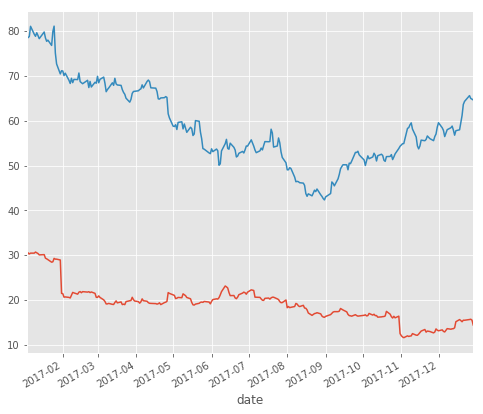

In [246]:
close_UAA.plot(label='Close')
close_HP.plot()

plt.show()

In [240]:
low=UAA_df['low'].asfreq('D')

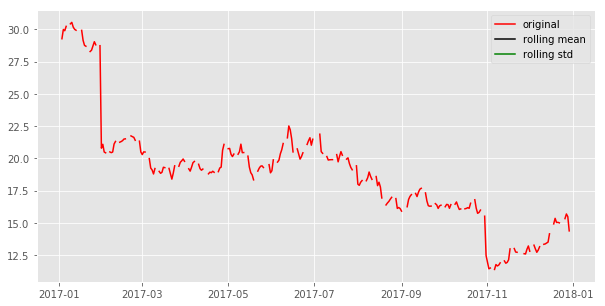

In [241]:
def plot_rolling(UAA_df,window=100):
    rolling_mean=UAA_df.rolling(window).mean()
    rolling_std=UAA_df.rolling(window).std()
    plt.figure(figsize=(10,5))
    plt.plot(UAA_df,label='original',color='red')
    plt.plot(rolling_mean,label='rolling mean',color='black')
    plt.plot(rolling_std,label='rolling std',color='green')
    plt.legend(loc='best')
    plt.show()
    
plot_rolling(low)

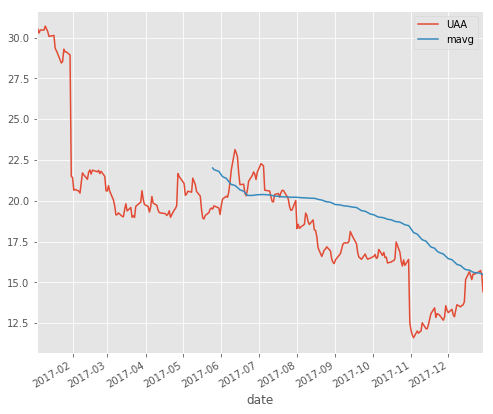

In [234]:
mavg = close_UAA.rolling(window=100).mean()
# Adjusting the size of matplotlib
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_UAA.plot(label='UAA')
mavg.plot(label='mavg')
plt.legend()